In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt

In [57]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'
mpath = '/tmp/sshfs/ampaim/'

In [3]:
###
# Load AB mapping file
###

# get AMPAIM+EISER mapping file w metadata; drop row 1
df_map_AB = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# get first row for any future operations
first_row = df_map_AB.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map_AB = df_map_AB.iloc[1:,]


###
# Specific replacements
###

# 526-0-twin-psaplate308 is missing a dash
df_map_AB = df_map_AB.rename(index={'526-0-twin-psaplate308': '526-0-twin-psa-plate308'})

###
# General replacements
###

# refrain from dropping NA's because you might need the columns for Q2 and you need to smoothly concat the first row

# convert index to str from float etc.
df_map_AB.index = df_map_AB.index.map(str)

# switch EISER diagnosis to eiser from NA
df_map_AB.loc[df_map_AB['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# RBB mapping file doesn't have info on duplicate controls, and the glass control info is extracted only from a subset of the names
# so we need to grab that info from AB's mapping file
samp_to_ctrlstatus = df_map_AB['Project'].to_dict()

# grab AB non-microteach samples
df_map_AB_filt = df_map_AB[df_map_AB['Project'].isin(['eiser','TWIN_PSA','glass_control','neg_control','duplicate_control'])]

df_map_AB_filt.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,ACGGCGTTATGT,CCGGACTACHVGGGTWTCTAAT,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [4]:
###
# Prepare for merge with RB mapping file
###

# load RB mapping file
df_map_RB = pd.read_csv(path + 'inputs/qiime_mapping_file_final_062123_RBB_ESR_CRPmod.csv', index_col=0)

# skip row with q2types; 140 columns
df_map_RB = df_map_RB.iloc[1:,]

# exclude unaffected since we are using TWINS_PSA from AB and controls from AB
# we only want microteach samples
df_map_RB = df_map_RB[df_map_RB['Diagnosis'].isin(['healthy','ss','sle','cd','RA','psa','pso'])]

# drop duplicate samples that appear in AB and that are controls per AB mapping file
for s in list(df_map_RB.index.values):
    if samp_to_ctrlstatus[s] in ['glass_control','duplicate_control','neg_control']:
        df_map_RB = df_map_RB.drop(s)
        
        
# merge with AB
df_meta = pd.concat([df_map_AB_filt, df_map_RB], axis=0)

# drop 'Separate' and 'Together'; presumably Q2 artifacts
df_meta = df_meta.drop(['Separate','Together'], axis=1)

# add in Project col from AB that describes controls
df_meta['Project'] = df_meta.index.map(samp_to_ctrlstatus)

###
# Specific replacements
###

# replace HxOtherDMARDs
df_meta.loc['540-0-twin-psa-plate308','HxOtherDMARDs'] = 'N'

### 
# General replacements
###

# specify float cols for later
float_cols = ['Age','BSA','CRP','DAS28','ESR','PhysicianGlobalPsA','RAPID3','SJC','TJC']

# Replace Y,N with 1,0 
df_meta = df_meta.replace({'Y':1,'N':0})

# create dict mapping diagnosis to samples
diag_to_samp = {}
for d in list(set(df_meta['Diagnosis'].values)):
    diag_to_samp[d] = list(df_meta[df_meta['Diagnosis'] == d].index.values)

### 
# Create new mapping files
### 

def export_q2(df, first_row_df):
    df_q2 = df.reset_index()
    df_q2 = pd.concat([first_row_df, df_q2])
    df_q2 = df_q2.set_index('#SampleID')
    df_q2.loc['#q2:types',:] = 'categorical'
    df_q2 = df_q2.reset_index()
    return df_q2

# (1) filter out controls
df_meta = df_meta[df_meta['Project'].isin(['eiser','microteach','TWIN_PSA'])]

# (2) filter out treatments
# drop TWIN PSA and PSO samples that have treatment on biologics, DMARDS, MTX
drop_samples = ['275-psa-plate307', '475-psa-plate307', '542-0-twin-psa-plate308']
df_meta = df_meta.drop(drop_samples)

# remove samples that are treated other than above
drops = []
for v in ['CurrentBiologics', 'CurrentOtherDMARDs', 'CurrentMTX', 'HxOtherDMARDs']:
    df = df_meta[df_meta[v].isin(['Y',1])]
    drops = drops + list(df.index.values)

df_meta = df_meta.drop(drops)
print('Dropped this many samples: ' + str(len(drops)))

# drop eiser samples from downstream analysis
df_meta = df_meta[df_meta['Diagnosis'] != 'eiser']

# drop CD 
df_meta = df_meta[df_meta['Diagnosis'] != 'cd']

# drop unaffected twins
df_meta = df_meta[df_meta['Diagnosis'] != 'unaffected']

# export to Q2
df_meta_q2 = export_q2(df_meta, first_row_df)
df_meta_q2.to_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_nocd.tsv', sep='\t', index=False, na_rep='nan') 


###
# Pre-processing
###

df_meta['Diagnosis'].value_counts()

Dropped this many samples: 18


Diagnosis
RA         41
psa        27
pso        25
healthy     6
ss          5
sle         4
Name: count, dtype: int64

In [109]:
# merge CDP and MSQ141 MMEDs qiime mapping files
# load CDP
df_cdp = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_nocd.tsv', sep='\t')
df_cdp['Batch'] = 'CDP'

# load MSQ141
df_141 = pd.read_csv(path + 'inputs/qiime_mapping_file_MSQ141.tsv', sep='\t')

# drop row 0 (#q2types) prior to merge
df_141 = df_141.iloc[1:,:]
df_141['Batch'] = 'MSQ141'

# add in diagnosis column that is IllnessNotes to all lowercase
df_141['Diagnosis'] = df_141['IllnessNotes'].apply(lambda x: x.lower())

# replace sjd with ss and psa_pso with psa
df_141['Diagnosis'] = df_141['Diagnosis'].replace('sjd','ss')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('psa_pso','psa')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('ra','RA')

# export
df_141_q2 = export_q2(df_141, first_row_df)
df_141_q2.to_csv(path + 'inputs/qiime_mapping_file_MSQ141_fixdiag.tsv', sep='\t', index=False, na_rep='nan') 

# merge rows
df_merge = pd.concat([df_cdp, df_141])#, axis=1)
df_merge = df_merge.set_index('#SampleID')
df_merge.loc['#q2:types',:] = 'categorical'

# note that lots of reasons might exist for batch effect, like treatment, also different diseases
# columns are not consistent (e.g. IllnessNotes in MSQ141 vs Diagnosis in CDP)
df_merge.to_csv(path + 'inputs/qiime_mapping_file_batch_nocd.tsv', sep='\t')

# standard binarize column for each medication
# convert from float
df_merge['Medication'] = df_merge['Medication'].astype(str)


# grab all medications
meds = list(df_merge['Medication'].values)

# drop 'categorical'
meds.remove('categorical')

uniq_meds = []
# split items with '_'
for m in meds:
    if '_' in m:
        items = m.split('_')
        items = [i.lower() for i in items]
        uniq_meds = uniq_meds + items
    else:
        uniq_meds.append(m.lower())
    
uniq_meds = list(set(list(uniq_meds)))
print(uniq_meds)

# create new column for each med
for u in uniq_meds:
    df_merge[u] = 0
    df_merge.loc[0,u] = 'categorical'

# iterate through each sample
for index, row in df_merge.iterrows():
    if index != 0: # the whole '#q2:types', 'categorical' thing
        medications = df_merge.loc[index,'Medication'].lower()
        medications = medications.split('_')
        for m in medications:    
            df_merge.loc[index,m] = 1

# new mapping file with med columns
df_merge = df_merge.drop(0)

# create involvement
def classify_psa(type):
    if type == 'peripheral':
        return 'peripheral'
    elif type == 'mixed' or type == 'axial': 
        return 'axial'
    else:
        return np.nan

df_merge['Involvement'] = df_merge['PsAtype'].apply(lambda x: classify_psa(x))

# create copy df meta
df_meta = df_merge.copy()
df_meta = df_meta.drop('#q2:types')
df_merge.loc['#q2:types',:] = 'categorical'
df_merge = df_merge.reset_index()
df_merge.to_csv(path + 'inputs/qiime_mapping_file_merge_meds.tsv', sep='\t', index=False, na_rep='nan')

df_merge.head()

['nan', 'hcq', 'mtx', 'nomed', 'prednisone', 'topicals', 'leflunomide']


,#SampleID,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,...,AgeAtVisit,nan,hcq,mtx,nomed,prednisone,topicals,leflunomide,categorical,Involvement
0,#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
1,518-0-twin-psa-plate308,AGCCCTGCTACA,CCGGACTACHVGGGTWTCTAAT,A3,1.5,NaN,NaN,NaN,0.0,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
2,524-0-twin-psa-plate308,AGTAAAGATCGT,CCGGACTACHVGGGTWTCTAAT,E3,4,NaN,NaN,NaN,0.0,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
3,525-0-twin-psa-plate308,TTGCTGGACGCT,CCGGACTACHVGGGTWTCTAAT,F3,2,NaN,NaN,NaN,0.0,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
4,528-0-twin-psa-plate308,CCTAACGGTCCA,CCGGACTACHVGGGTWTCTAAT,A4,3.5,NaN,NaN,NaN,0.0,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN


In [110]:
# disease breakdown by sample numbers
df_141_q2['IllnessNotes'].value_counts()

IllnessNotes
Non-Sjogrens sicca    12
SjD                    5
PsO                    3
RA                     2
categorical            1
SLE                    1
PsA_PsO                1
Name: count, dtype: int64

KruskalResult(statistic=12.0904820568486, pvalue=0.05998043490265998)


Diagnosis
RA         43
PsO        28
PsA        28
NSS        12
SS         10
Healthy     6
SLE         5
Name: count, dtype: int64

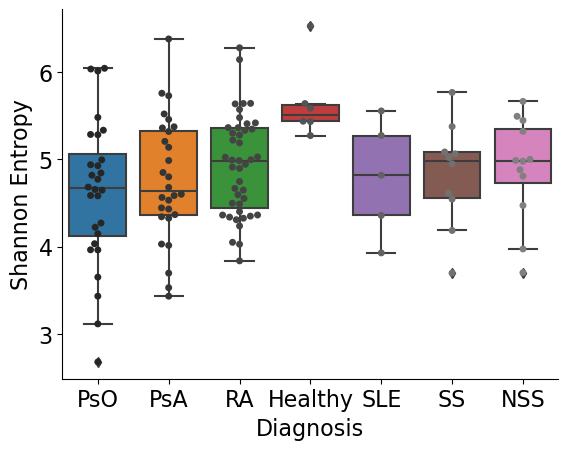

In [111]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# convert NSS to SICCA
df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace('non-sjogrens sicca','NSS')
df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace('pso','PsO')
df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace('psa','PsA')
df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace('sle','SLE')
df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace('ss','SS')
df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace('healthy','Healthy')

# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


In [112]:
# df_alpha[['Diagnosis','shannon_entropy']]
df = df_merge.set_index('#SampleID')
df = df.drop('#q2:types')#,axis=1)
df = pd.concat([df, df_alpha['shannon_entropy']],axis=1)

df141 = df_141_q2.set_index('#SampleID')
df141 = df141.drop('#q2:types')
s141 = df141.index.values
df = df.loc[s141,:]

from sklearn import linear_model
clf = linear_model.LinearRegression()

X = df[['hcq','mtx']].values
y = df['shannon_entropy'].values
# df = df[df['Diagnosis'].isin(['non-sjogrens sicca','ss'])]
df[['hcq','mtx','shannon_entropy','Diagnosis']].to_csv(path + 'inputs/df_ss_med_R.tsv', sep='\t')
        
clf.fit(X,y)
# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([1, 2])) + 3
# reg = LinearRegression().fit(X, y)
# reg.score(X, y)
# reg.coef_
# reg.intercept_


LinearRegression()

In [113]:
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2>]
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2> <aggregate group 2>]
comp_to_groups = {
    'AvH': (['healthy'],['psa','pso','ss','cd','sle','RA', 'non-sjogrens sicca'],['affected']), # healthy vs disease aggregate, jobs03
    'RAvH': (['healthy'],['RA'],['RA']), # jobs04 
    'PsOvH': (['healthy'],['pso','pso'],['PsA']), #jobs05
    'PsAvH': (['healthy'],['psa','psa'],['PsA']), #jobs05
    'SSvH': (['healthy'],['ss'],['ss']), #jobs06
    'SICCAvH': (['healthy'],['non-sjogrens sicca'],['non-sjogrens sicca']), #jobs06
    'SLEvH': (['healthy'],['sle'],['sle'])
}

for c in comp_to_groups:
    # unpack tuples
    healthy, disease, aggregate = comp_to_groups[c]
    
    # subset relevant diseases
    df_meta_XvH = df_merge[df_merge['Diagnosis'].isin(healthy + disease)]
    
    # change all diseases to aggregate string
    df_meta_XvH.loc[df_meta_XvH['Diagnosis'].isin(disease), 'Diagnosis'] = aggregate[0]

    # add first row
    df_meta_XvH = df_meta_XvH.reset_index()
    df_meta_XvH = pd.concat([first_row_df, df_meta_XvH])
    df_meta_XvH = df_meta_XvH.set_index('#SampleID')
    df_meta_XvH.loc["#q2:types",:] = 'categorical' 

    # export to csv
    df_meta_XvH.to_csv(path + 'inputs/qiime_mapping_file_merge_' + c + '.tsv', sep='\t', na_rep='nan')
    df_meta_XvH.head()

df_meta_XvH.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,AgeAtVisit,nan,hcq,mtx,nomed,prednisone,topicals,leflunomide,categorical,Involvement
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
SCFA08-B-plate308,AGCCTTCGTCGC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
MicraHC-1017-B-plate308,CGTATAAATGCG,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
MicraHC-1018-B-plate308,TGACTAATGGCC,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
MicraHC-1019-B-plate308,GTGGAGTCTCAT,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN


In [114]:
# unnormalized OTU table level-6 also has metadata in it! nice 
# from taxa_bar_plot.qzv
L_to_otu = {}
levels = [6,7]

# build dict of otu tables
for l in levels:
    # construct key
    level = 'L' + str(l)

    # read in df otu
    df_otu = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/level-' + str(l) + '.csv', index_col=0)
    
    # determine columns to drop; i.e. keep taxa only
    dropcol = []
    for c in list(df_otu.columns.values):
        if c[0:3] != 'd__':
            dropcol.append(c)
            
    # keep Diagnosis for later
    keepcol = df_otu['Diagnosis']
    
    df_otu = df_otu.drop(dropcol, axis=1)
    df_otu.to_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/counts_L' + str(l) + '.csv')
    
    # normalize the cols
    df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
    df_otu.to_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_L' + str(l) + '.csv')
    
    # reappend dx
    df_otu = pd.concat([df_otu, keepcol],axis=1)

    # add to dict 
    L_to_otu[level] = df_otu

L_to_otu['L6'].head()

,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Christensenellales;f__CAG-74;g__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__UBA11471;g__UBA11471,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Christensenellales;f__Christensenellaceae;g__Christensenella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Eubacterium_I,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus_A_187866,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Catenibacterium,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A_141781,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Oscillospiraceae_88309;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Limisoma,...,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Monoglobales;f__Monoglobaceae;g__Monoglobus,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales_592524;f__Burkholderiaceae_A_580492;g__Ralstonia,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__CAG-127,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__UBA6382,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__C-53,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__Baileyella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__;g__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales_650611;f__Pseudomonadaceae;g__Pseudomonas_F,Diagnosis
index,,,,,,,,,,,,,,,,,,,,,
131-slesjo-plate308,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.040652,0.002920,0.0,...,0.002221,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,ss
209-pso-plate307,0.000000,0.0,0.000220,0.000000,0.003604,0.000527,0.0,0.089495,0.000484,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,pso
235-psa-plate307,0.000000,0.0,0.000168,0.000000,0.000000,0.000000,0.0,0.268243,0.001178,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,psa
240-psa-plate307,0.000000,0.0,0.000000,0.000000,0.001677,0.000000,0.0,0.062114,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,psa
241-pso-plate307,0.003153,0.0,0.000039,0.000315,0.000000,0.000670,0.0,0.033149,0.024202,0.0,...,0.000000,0.0,0.000039,0.0,0.0,0.0,0.0,0.0,0.0,pso


In [115]:
# First go to R and run the DMM script to generate the cluster assignments and scores
#df_dmm = pd.read_csv(path + 'outputs/visualizations_dir_nyu/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
df_dmm = pd.read_csv(path + 'outputs/jobs19/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
df_final = pd.concat([df_meta, df_dmm], axis=1)
# df_final.index.name = '#SampleID'

# export for rerun Q2
df_disease = export_q2(df_final, first_row_df)
df_disease.to_csv(path + 'inputs/qiime_mapping_file_psara_dmm.tsv', sep='\t', index=False, na_rep='nan')

# assess chi square GOF
df_final = df_final.dropna(axis='rows', subset=['Diagnosis'])

# new col for SJ TJC binary
df_final['TJCpos'] = df_final['TJC'].map(lambda x: 1 if float(x) > 0 else 0)
df_final['SJCpos'] = df_final['SJC'].map(lambda x: 1 if float(x) > 0 else 0)

# DMM GROUPING
dmm = df_final['dmm.grp'].values
diag = df_final['Diagnosis'].values

# disease_grouping only exists if we grouped RA and PsA etc.
for col in ['Diagnosis']: # ,'disease_grouping_1','disease_grouping_2']:
    diag = df_final[col].values
    for d in list(set(diag)):
        y = np.array([0 if x == d else 1 for x in diag])
        x,p = scipy.stats.chisquare(f_obs=[dmm, y], axis=None)#, f_exp=None, ddof=0, axis=0)
        #if p<0.05:
        print(col)
        print(d)
        print(p)
print('Done')


Diagnosis
RA
1.0
Diagnosis
sle
1.0
Diagnosis
psa
1.0
Diagnosis
non-sjogrens sicca
1.0
Diagnosis
ss
1.0
Diagnosis
healthy
1.0
Diagnosis
pso
1.0
Done


In [146]:
# combine LEfSe results
# all files are lefse_table.tsv
# add 10 for L7 results, L6 is listed below
'''
outputs/
	jobs11							# LEfSe for PsAvH
	jobs10							# LEfSe for PsOvH
    jobs16                          # AvH
    jobs09                          # RAvH
    jobs12                          # SSvH
    jobs13                          # SLEvH
    jobs15                          # SS+SLE aka SSSLEvH        
    jobs14                          # NSS
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse = {}
diag_to_path = {}

for l in ['L6', 'L7']:
    diag_to_lefse_disease[l] = {
        'PsA': [],
        'PsO': [],
        'A': [],
        'RA': [],
        'SS': [],
        'SLE': [],
        # 'SSSLE': [],
        'NSS': [],
    }

diag_to_path['L6'] ={
    'PsA': 'outputs/jobs11/',
    'PsO': 'outputs/jobs10/',
    'A': 'outputs/jobs16/',
    'RA': 'outputs/jobs09/',
    'SS': 'outputs/jobs12/',
    'SLE': 'outputs/jobs13/',
    'NSS': 'outputs/jobs14/',
    # 'SSSLE': 'outputs/jobs15/',
}
diag_to_path['L7'] ={
    'PsA': 'outputs/jobs21/',
    'PsO': 'outputs/jobs20/',
    'A': 'outputs/jobs26/',
    'RA': 'outputs/jobs19/',
    'SS': 'outputs/jobs22/',
    'SLE': 'outputs/jobs23/',
    'NSS': 'outputs/jobs24/',
    # 'SSSLE': 'outputs/jobs25/',
}
# '' is disease, otherwise healthy
for l in ['L6','L7']:
    for h in ['healthy_','']:
        # common to all
        print(h)
        for diag in diag_to_path[l]:        
            # import df, rename columns
            df_lefse = pd.read_csv(path + diag_to_path[l][diag] + 'lefse_results.res', sep='\t', header=None)    
            df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
            
            # replace dash with nan, cast to float
            df_lefse = df_lefse.replace('-', np.nan)
            df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
            
            # get sig results and results pertaining to enriched group
            df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
            if h == 'healthy_':
                df_lefse = df_lefse[df_lefse['Enriched_Group'] == 'healthy']
            else:
                df_lefse = df_lefse[df_lefse['Enriched_Group'] != 'healthy']
            
            # drop na
            df_lefse = df_lefse.dropna()
            
            print(diag)
            print(len(df_lefse))
            if h == '':
                print(df_lefse.Taxa.values)
            if diag == 'PsA':
                shared = set(df_lefse['Taxa'].values)
            else:
                shared = shared.intersection(set(df_lefse['Taxa'].values))
            
            #df_lefse = df_lefse.sort_values('Effect_Size')
            df_lefse.to_csv(path + 'outputs/jobs04/' + l + '_' + diag + '_lefse_' + h + 'sig.tsv', sep='\t')
            diag_to_lefse_disease[l][diag] = list(df_lefse['Taxa'].values)
    
        print(shared)
# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




healthy_
PsA
64
PsO
54
A
55
RA
39
SS
26
SLE
14
NSS
23
{'d__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A'}

PsA
1
['d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ']
PsO
1
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__CAG_272.g__QALR01']
A
2
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__CAG_272.g__QALR01'
 'd__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Muribaculaceae.__']
RA
1
['d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Prevotella']
SS
2
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__Oscillospiraceae_88309.g__Lawsonibacter'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Lachnospirales.f__Lachnospiraceae.g__Clostridium_Q_134516']
SLE
3
['d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clost

In [117]:
# taxa of interest
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri'
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae'
#pcopri = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium'
#pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae'
#pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Oxalobacter'
#pcopri ='k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae'
#taxas = ['d__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;__',
#        'd__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__',
#        'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium']

taxas = ['d__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A',
         'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri']

for t in range(len(taxas)):
    original = taxas[t].replace('.',';')
    taxa = original.split('__')[-1]
    print(taxa)
    
    if 'copri' in taxa:
        df_otu = L_to_otu['L7'].copy()
        df_otu_spec = df_otu[df_otu['Diagnosis'].isin(['RA','healthy'])]

    if 'Phas' in taxa:
        df_otu_spec = L_to_otu['L6'].copy()
    
    # replacements for figure formatting
    df_otu_spec['Diagnosis'] = df_otu_spec['Diagnosis'].replace('non-sjogrens sicca','NSS')
    df_otu_spec['Diagnosis'] = df_otu_spec['Diagnosis'].replace('pso','PsO')
    df_otu_spec['Diagnosis'] = df_otu_spec['Diagnosis'].replace('psa','PsA')
    df_otu_spec['Diagnosis'] = df_otu_spec['Diagnosis'].replace('sle','SLE')
    df_otu_spec['Diagnosis'] = df_otu_spec['Diagnosis'].replace('ss','SS')
    df_otu_spec['Diagnosis'] = df_otu_spec['Diagnosis'].replace('healthy','Healthy')
    
    
    # KW test
    print(scipy.stats.kruskal(*list(df_otu_spec.groupby('Diagnosis')[original].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))
    
    # do sns 
    ax = sns.boxplot(data=df_otu_spec, x='Diagnosis', y=original)
    sns.swarmplot(data=df_otu_spec, x='Diagnosis', y=original, palette='dark:grey', hue=None)
    
    # formatting
    ax.set_ylabel(taxa,fontsize=16)
    ax.set_xlabel("Disease",fontsize=16)
    ax.tick_params(labelsize=16)
    sns.despine()
    plt.savefig(path + 'outputs/jobs00/' + taxa + '.pdf')
    plt.close()
    # sns.boxplot([RA_pc, H_pc])

Phascolarctobacterium_A
KruskalResult(statistic=12.944717632463972, pvalue=0.043922283304510035)
Prevotella copri
KruskalResult(statistic=2.2044729573197923, pvalue=0.13761091850532498)


In [137]:
# across psa, ra do CRP DAS 28 etc
# metadata box plot with diagnosis
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
for q in qvars:
    df_meta[q] = df_meta[q].astype(float)
    df = df_meta[['Diagnosis',q]].dropna(how='any')
    k,p = scipy.stats.kruskal(*list(df.groupby('Diagnosis')[q].apply(list).values), nan_policy='omit', axis=0, keepdims=False)
    print(q)
    print(k,p)
    
    # do sns 
    ax = sns.boxplot(data=df, x='Diagnosis', y=q)
    sns.swarmplot(data=df, x='Diagnosis', y=q, palette='dark:grey', hue=None)
    
    # ax.axes.set_title("Title",fontsize=48)
    ax.set_ylabel(q,fontsize=16)
    ax.set_xlabel("Diagnosis",fontsize=16)
    ax.tick_params(labelsize=16)
    plt.title("{:.2e}".format(p),fontsize=16)
    #plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()
    plt.savefig(path + 'outputs/jobs01/dx_meta/' + q + '.pdf')
    plt.close()



BSA
2.938502852465311 0.08649086497315725
CRP
4.163805283663806 0.1246927407339942
ESR
17.637211195086667 0.0001479545246131646
DAS28
13.969760269482073 0.0009257742581426961
TJC
26.25575734678258 1.988999770670598e-06
SJC
32.26087762696217 9.877327018515363e-08


In [119]:
df_alpha['Diagnosis'].value_counts()

Diagnosis
RA         43
PsO        28
PsA        28
NSS        12
SS         10
Healthy     6
SLE         5
Name: count, dtype: int64

In [127]:
# metadata correlation with adiv
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
dx = [['PsA'],['PsO'],['RA'],['PsA','PsO','RA']]
for q in qvars:
    df_meta[q] = df_meta[q].astype(float)

    # grab for PsA only, PsO only, RA only, and then combine all 3
    for d in dx:
        df = pd.concat([df_alpha[df_alpha['Diagnosis'].isin(d)]['shannon_entropy'], df_meta[q]],axis=1)
        r, p = scipy.stats.spearmanr(df['shannon_entropy'],df[q], nan_policy='omit')
        if p < 0.05:
            print(q, d, p)
                
        # do sns 
        ax = sns.lmplot(data=df, x='shannon_entropy', y=q)
        
        plt.title(str(d),fontsize=16)
        #ax.set_ylabel(q,fontsize=16)
        #ax.set_xlabel("Shannon Entropy",fontsize=16)
        #ax.tick_params(labelsize=16)
        plt.tight_layout()
        sns.despine()
        plt.savefig(path + 'outputs/jobs01/alpha_corr/' + q + '_' + str(d) + '_' + str(p)[0:5] + '.pdf')
        plt.close()



CRP ['PsO'] 0.0


In [121]:
# need a cutie job for
# each AMP AIM disease; actually only PsA PsO and RA and each subset have clinical metadata
# subset each mapping file on the disease of interest
# use the same L6, L7 table
# PsA ax vs periph

from itertools import chain, combinations

def subsets_iterative(lst):
    return list(chain.from_iterable(combinations(lst, r) for r in range(len(lst)+1)))

from pathlib import Path

dx = ['psa','pso','RA']
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
levels = ['L6', 'L7']

dx_sets = subsets_iterative(dx)[1:]

for d in dx_sets:
    # get string descriptor 
    diag = '_'.join(['{}']*len(d)).format(*d)
    
    for l in levels:
        # Specify the directory path
        wd = Path(path + 'outputs/jobs02/' + l + '_' + diag)

        # Create the directory recursively
        wd.mkdir(parents=True, exist_ok=True)

    # Create input mapping files
    df = df_meta[df_meta['Diagnosis'].isin(d)][qvars + ['Diagnosis','Involvement']]
    df.to_csv(path + 'inputs/df_meta_' + diag + '.tsv', sep='\t')

# L_to_otu['L6']

# df_meta

In [122]:
pd.DataFrame()

""


In [144]:
# examine the LEfSe taxa and look in the CUTIE jobs for corr w differential taxa
'''
outputs/
	jobs11							# LEfSe for PsAvH
	jobs10							# PsOvH
    jobs09                          # RAvH
'''
# where LEfSe results are stored
diag_to_path = {}
diag_to_path['L6'] ={
    'psa': 'outputs/jobs11/',
    'pso': 'outputs/jobs10/',
    'RA': 'outputs/jobs09/'
}
diag_to_path['L7'] ={
    'psa': 'outputs/jobs21/',
    'pso': 'outputs/jobs20/',
    'RA': 'outputs/jobs19/'
}

levels = ['L6','L7']
for l in levels:
    for d in dx_sets:    
        dx = '_'.join(['{}']*len(d)).format(*d)
        print(dx)
        # grab cutie taxa
        df_qt = pd.read_csv(path + 'outputs/jobs02/' + l + '_' + dx + '/data_processing/summary_df_resample_1.txt', sep='\t')
    
        # get sig subset
        df_qt = df_qt[df_qt['class'].isin(['TP'])]#,'FP'])]
        cutie_taxa = df_qt['var2'].values
        for x in cutie_taxa:
            if 'copri' in x:
                print(x)
    
        # get all possible subsets
        for diag in dx.split('_'):
            # import df, rename columns
            df_lefse = pd.read_csv(path + diag_to_path[l][diag] + 'lefse_results.res', sep='\t', header=None)    
            df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
            
            # replace dash with nan, cast to float
            df_lefse = df_lefse.replace('-', np.nan)
            df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
            
            # get sig results and results pertaining to enriched group
            df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
            
            # drop na
            df_lefse = df_lefse.dropna()
        
            # diff taxa
            lefse_taxa = [x.replace('.',';') for x in list(df_lefse['Taxa'].values)]
        
            # check overlap
            taxa = set(cutie_taxa).intersection(set(lefse_taxa))
            print(len(taxa))
            print(diag,taxa)
            print([list(L_to_otu[l].columns.values).index(x) for x in taxa])
    
            # save overlap
            df_res = df_qt[df_qt['var1'].isin(taxa)]
            df_res.to_csv(path + 'outputs/jobs02/' + l + '_' + dx + '/' + diag + '_lefse.tsv', sep='\t')








psa
3
psa {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__', 'd__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;__', 'd__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A'}
[145, 90, 77]
pso
2
pso {'d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871404', 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_Q_135822'}
[196, 134]
RA
1
RA {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125'}
[182]
psa_pso
2
psa {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__', 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__UBA644;g__UBA644'}
[145, 72]
4
pso {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g_

In [106]:
cutie_taxa

array(['BSA', 'BSA', 'BSA', 'BSA', 'BSA', 'BSA', 'BSA', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'ESR', 'ESR', 'ESR', 'ESR', 'ESR',
       'ESR', 'ESR', 'ESR', 'ESR', 'ESR', 'ESR', 'ESR', 'ESR', 'ESR',
       'ESR', 'ESR', 'ESR', 'ESR', 'DAS28', 'DAS28', 'DAS28', 'DAS28',
       'DAS28', 'DAS28', 'DAS28', 'DAS28', 'DAS28', 'DAS28', 'TJC', 'TJC',
       'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC',
       'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'TJC',
       'TJC', 'TJC', 'TJC', 'TJC', 'TJC', 'SJC', 'SJC', 'SJC', 'SJC',
       'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC',
       'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC', 'SJC',
       'SJC', 'SJC'], dtype=object)

In [ ]:
# correlation of beta div with SJC and CRP
df_pcoa = pd.read_csv(path + 'inputs/Qiime2_psara_dmm/core_metrics_results/ordination.txt', 
                      sep='\t', 
                      header=None,
                      index_col=0,
                      skiprows=9)#error_bad_lines=False)#on_bad_lines='skip')
df_pcoa = df_pcoa.drop(['Biplot','Site constraints'])
df_pcoa.columns = df_pcoa.columns.map(lambda x: 'X' + str(x))

df_test = pd.concat([df_final, df_pcoa], axis=1)
df_test.head()

pcs = ['X1', 'X2', 'X3']
var = ['SJC', 'CRP', 'CRP_drop']
for x in pcs:
    for y in var:
        print(x)
        print(y)
        
        if y == 'CRP_drop':
            y = 'CRP'
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)
            df_corr[y] = df_corr[y].map(lambda x: 0 if x > 175 else x)
            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + 'CRP_drop' + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)

        else:
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)

            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + y + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)


In [ ]:
# SJC?
df_sub = df_meta_sub[['dmm.grp', 'SJC']]
df_sub = df_sub.dropna()
a = df_sub[df_sub['dmm.grp'] == 1]['SJC'].values
b = df_sub[df_sub['dmm.grp'] == 2]['SJC'].values
t, p = scipy.stats.ttest_ind(a, b)
print(t, p)

sns.boxplot([a, b])


In [139]:
for x in list(df_otu_spec.columns.values):
    if 'lute' in x: #Oxalo
        print(x)
    
df_otu_spec[pcopri].value_counts()


k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae


k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae
0.000000    101
0.005607      1
0.282243      1
0.004148      1
Name: count, dtype: int64

In [33]:
# for R to do mediation analysis
df_meta_filt = df_meta[float_cols]

# merge OTU and df_meta
df_complete = pd.concat([df_otu, df_meta_filt], axis=1)

# subset on CRP, DAS28, ESR, SJC and TJC along with taxa
meta = ['CRP', 'DAS28', 'ESR', 'SJC', 'TJC']
df_complete = pd.concat([df_otu[taxas], df_meta_filt[meta]], axis=1)

# rename
df_complete = df_complete.rename(columns={k: v for k, v in zip(taxas,['Rikenellaceae_f','Rikenellaceae_g','Pharscolarctobacterium'])})

# export to R mediation
df_complete.to_csv(path + 'outputs/jobs01/mediation.tsv', sep='\t')
df_complete.head()


,Rikenellaceae_f,Rikenellaceae_g,Pharscolarctobacterium,CRP,DAS28,ESR,SJC,TJC
131-slesjo-plate308,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
209-pso-plate307,0.001231,0.001451,0.022813,NaN,2.68,10,0,2
235-psa-plate307,0.000000,0.000000,0.000000,NaN,NaN,NaN,0,1
240-psa-plate307,0.000000,0.000000,0.008384,NaN,3.72,NaN,0,7
241-pso-plate307,0.000000,0.001616,0.001458,NaN,NaN,NaN,0,0


In [40]:
# check for abx usage: 1 out of 60 w values
# df_meta['AbxInPast3Months'].value_counts()
# df_meta.HxOtherDMARDs.value_counts() # NONE

# check for HCQ, MTX usage
# df_meta.columns.values
df_meta.hxMTX.value_counts() # 5 to 72


hxMTX
0.0    72
1.0     5
Name: count, dtype: int64

In [24]:
# PICRUST2
# don't forget to uncompress path_abun_unstrat.tsv.gz
# 393 columns/pathways represented here
df_fxn = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/PiCRUSt2_0/picrust2_out/pathways_out/path_abun_unstrat.tsv', sep='\t', index_col=0).T
KO_names = list(df_fxn.columns.values)

# normalize by row total (per sample basis)
df_fxn = df_fxn.div(df_fxn.sum(axis=1), axis=0)
# df_fxn.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

# new metadata for concatenation
# df_meta_sample = df_meta.set_index('SampleID')

# concatenate
# df_pi = pd.concat([df_meta_sample, df_fxn], axis=1)
# df_pi.head()

#gene names; KO is just a placeholder
# KO_names = [x for x in df_pi.columns.values if x[0] == 'K']
# KO_names = [x for x in df_pi.columns.values if x[-3:] == 'PWY']

# RA first
# df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','RA'])]#'pso','psa'])]
# df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
# df_ra_KO = df_KO[df_KO['Diagnosis'].isin(['RA'])]#'pso','psa'])]
# df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]


df_fxn.head()

pathway,1CMET2-PWY,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,ALL-CHORISMATE-PWY,ANAEROFRUCAT-PWY,ANAGLYCOLYSIS-PWY,ARG+POLYAMINE-SYN,ARGDEG-PWY,ARGORNPROST-PWY,ARGSYN-PWY,ARGSYNBSUB-PWY,...,THISYN-PWY,THREOCAT-PWY,THRESYN-PWY,TRNA-CHARGING-PWY,TRPSYN-PWY,TYRFUMCAT-PWY,UBISYN-PWY,UDPNAGSYN-PWY,VALDEG-PWY,VALSYN-PWY
116783-plate305,0.006894,0.000000,0.000021,0.007520,0.008957,0.002952,0.000000,0.000345,0.005476,0.005329,...,0.005385,0.000000,0.008002,0.007885,0.005062,0.0,0.000353,0.005087,0.0,0.008914
116784-plate305,0.006424,0.000000,0.000000,0.005238,0.008203,0.002061,0.000000,0.000111,0.004180,0.003247,...,0.005658,0.000000,0.007842,0.007343,0.005919,0.0,0.000061,0.003929,0.0,0.008255
116785-plate305,0.006937,0.000000,0.000000,0.006335,0.008470,0.001367,0.000000,0.000147,0.005108,0.004487,...,0.006907,0.000000,0.008267,0.007242,0.006189,0.0,0.000157,0.002773,0.0,0.008233
116786-plate305,0.006875,0.000000,0.000000,0.006683,0.008730,0.001332,0.000000,0.000121,0.004380,0.003672,...,0.006604,0.000000,0.008148,0.007263,0.006077,0.0,0.000005,0.002675,0.0,0.008247
116787-plate305,0.006765,0.000005,0.000075,0.004806,0.008774,0.002166,0.000008,0.000349,0.005773,0.005783,...,0.004919,0.000014,0.008432,0.008030,0.005553,0.0,0.000330,0.005199,0.0,0.008833


In [25]:
# get filtered meta for float cols only
df_meta_filt = df_meta[float_cols]

# merge OTU and df_meta
# df_complete = pd.concat([df_otu, df_meta_filt, df_fxn], axis=1)
df_complete = pd.concat([df_otu, df_meta_filt], axis=1)

# subset on CRP, DAS28, ESR, SJC and TJC along with taxa
df_complete = pd.concat([df_otu, df_meta_filt[], axis=1)
df_complete.head()

,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__vadinCA11,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia,...,Diagnosis,Age,BSA,CRP,DAS28,ESR,PhysicianGlobalPsA,RAPID3,SJC,TJC
131-slesjo-plate308,0.000000,0.0,0.0,0.000222,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,SS,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209-pso-plate307,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,PsO,47,3,NaN,2.68,10,NaN,NaN,0,2
235-psa-plate307,0.000000,0.0,0.0,0.000000,0.0,0.000421,0.000000,0.0,0.000000,0.0,...,PsA,54,3,NaN,NaN,NaN,NaN,NaN,0,1
240-psa-plate307,0.000000,0.0,0.0,0.000000,0.0,0.000381,0.000000,0.0,0.000000,0.0,...,PsA,37,13,NaN,3.72,NaN,NaN,NaN,0,7
241-pso-plate307,0.366338,0.0,0.0,0.000000,0.0,0.001025,0.000158,0.0,0.000434,0.0,...,PsO,69,7,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
# aggregate disease vs healthy analysis first
diag_healthy = ['healthy'] #['unaffected','healthy']
diag_disease = ['RA', 'psa', 'pso', 'ss', 'cd', 'sle']

# 
samp_healthy, samp_disease = [], []
for d in diag_healthy:
    samp_healthy = samp_healthy + diag_to_samp[d]
for d in diag_disease:
    samp_disease = samp_disease + diag_to_samp[d]
    
df_complete_healthy = df_complete.loc[samp_healthy]
df_complete_disease = df_complete.loc[samp_disease]

# save with index_label to avoid CUTIE errors
df_complete_healthy.to_csv(path + 'inputs/df_complete_healthy.tsv', sep='\t', index_label='Samples')
df_complete_disease.to_csv(path + 'inputs/df_complete_disease.tsv', sep='\t', index_label='Samples')

df_complete_healthy.head()




In [ ]:
# plotting differential picrust metacyc pathways
pvals = []
tvals = []
KO = KO_names#[0:1000]

# get OG p values
for k in KO:
    x = df_complete_healthy[k].values
    y = df_complete_disease[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    # remove nans or else, but this might not be the best way
    # https://github.com/statsmodels/statsmodels/issues/2899
    if np.isnan(p):
        pvals.append(1)
    else:
        pvals.append(p)
        tvals.append(t)


# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
# one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
# scipy.stats.false_discovery_control(ps)

df_complete_nonfilt = pd.concat([df_otu, df_meta, df_fxn], axis=1)

try:
    os.mkdir(path + 'outputs/metacycp/')
except:
    pass

try:
    os.mkdir(path + 'outputs/metacycq/')
except:
    pass


# convert to q values
sig_list = []
for i in range(len(KO)):
    p, q = pvals[i], qvals[i]
    k = KO[i]      
    if p < 0.05:        
        sig_list.append(k)
        print(k)
        print(tvals[i], pvals[i])
        sns.set(style="darkgrid")
        plt.subplots(figsize=(6, 4))
        plt.tight_layout()
        ax = sns.boxplot(data=df_complete_nonfilt, x='Diagnosis', y=k)

        # save the plot as PNG file
        plt.savefig(path + 'outputs/metacycp/' + k + '.png',  bbox_inches="tight")
        if q < 0.05:
            plt.savefig(path + 'outputs/metacycq/' + k + '.png',  bbox_inches="tight")
            
        plt.close()
                        
            
print(len(sig_list))



PsA
25
PsO
19
A
26
RA
17
SS
13
SLE
5
SSSLE
0
PsA
1
PsO
0
A
1
RA
4
SS
0
SLE
0
SSSLE
9


In [ ]:
# input query as list of sets
query = []
# query = ['SLE','SSSLE','RA','RAPsA','SS','PsO','PsA','PS','A']
query = ['PS','A']
query = ['RA','RAPsA']

# compute intersection 
result = set.intersection(*[set(diag_to_lefse_disease[q]) for q in query])
print(len(result))
print(result)


In [ ]:
# input query as list of sets
query = []
query = ['SLE','SSSLE','RA','RAPsA','SS','PsO','PsA','PS','A']
query = ['SLE','RA','SS','PsO','PsA']

# compute intersection 
result = set.intersection(*[set(diag_to_lefse_healthy[q]) for q in query])
print(len(result))
print(result)
